#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 15
**CH15A Predicting used car value with regression trees**

using the used-cars dataset

version 0.91 2021-01-19

In [1]:
import os
import random
import sys
import warnings
from collections import Counter
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image, display
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch15-used-cars-cart/"
output = dirname + "da_case_studies/ch15-used-cars-cart/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")
#data = pd.read_csv("https://osf.io/7gvz9/download")


In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [6]:
data["condition"].value_counts()


excellent    139
good         114
like new      55
fair          15
new            4
Name: condition, dtype: int64

In [7]:
data["condition"] = data["condition"].fillna("good")


In [8]:
data["condition"].value_counts()


good         336
excellent    139
like new      55
fair          15
new            4
Name: condition, dtype: int64

In [9]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("type not in ['truck','pickup']")

# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [10]:
# to be on the safe side
data = data[data["price"].notna()]
data = data.reset_index()


In [11]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3
data.to_csv("usedcars_work.csv", index=False)


In [12]:
data.price.describe()


count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [13]:
smp_size = np.floor(0.7 * data.shape[0])


In [14]:
# Initialize random seed to make it reproducible
random.seed(42)
train_ids = random.sample(range(0, data.shape[0]), int(smp_size))

data["train"] = 0
data["train"][train_ids] = 1


In [15]:
data["train"].value_counts()


1    333
0    144
Name: train, dtype: int64

In [16]:
data_train = data.query("train==1")
data_test = data.query("train==0")


### Regression tree
---

In [17]:
data_train.price.describe()


count      333.000000
mean      5642.117117
std       4230.532408
min        500.000000
25%       2499.000000
50%       3999.000000
75%       7700.000000
max      17777.000000
Name: price, dtype: float64

In [18]:
cart1 = DecisionTreeRegressor(random_state=20108, max_depth=1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart1.fit(X, Y)


DecisionTreeRegressor(max_depth=1, random_state=20108)

In [19]:
pred_cart1 = cart1.predict(data_test[["age"]])

rmse_cart1 = np.sqrt(mean_squared_error(data_test["price"], pred_cart1))


In [20]:
def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))


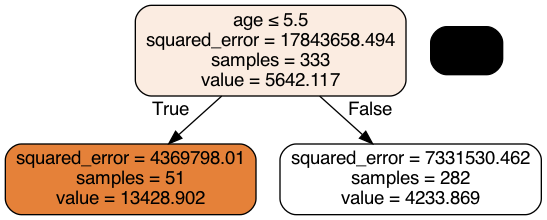

In [21]:
jupyter_graphviz(
    cart1, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [22]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart1.predict(plot_helper_df[["age"]])
pred_cart1t = cart1.predict(data_train[["age"]])


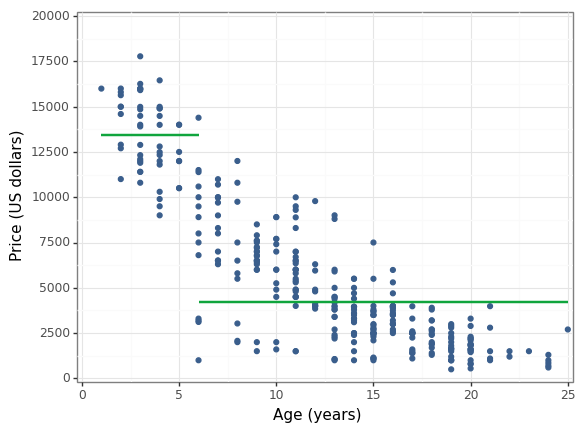

<ggplot: (390237844)>

In [23]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


In [24]:
###########
# Splits at two levels
# (make sure it stops by setting "max_depth" to 2)


In [25]:
cart2 = DecisionTreeRegressor(random_state=2018, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart2.fit(X, Y)


DecisionTreeRegressor(max_depth=2, random_state=2018)

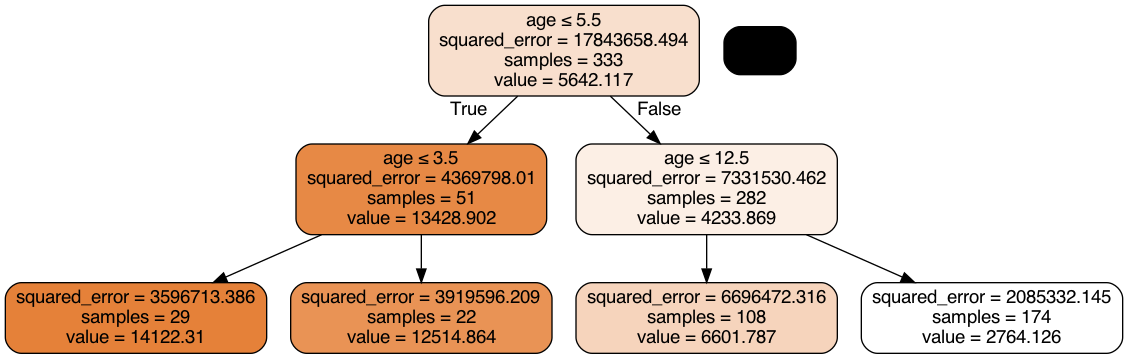

In [26]:
jupyter_graphviz(
    cart2, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [27]:
# Cut points
cuts = cart2.tree_.threshold[cart2.tree_.threshold != -2]

# Groups
groups = [0]
for x in cuts:
    groups += [int(np.floor(x)), int(np.floor(x) + 1)]

groups = sorted(groups) + ["or more"]


In [28]:
# get the leaf for each training sample
leaves_index = cart2.apply(X)

# use Counter to find the number of elements on each leaf
cnt = Counter(sorted(leaves_index))

# and now you can index each input to get the number of elements
elems = [cnt[x] for x in leaves_index]


In [29]:
counts = list(cnt.values())


In [30]:
av_price = (
    pd.DataFrame({"index": leaves_index, "fit": cart2.predict(X)})
    .drop_duplicates()
    .sort_values("index")["fit"]
    .tolist()
)


In [31]:
pd.DataFrame(
    {
        "Category": [
            y
            for x, y in enumerate(
                [
                    "Age " + str(groups[i]) + "-" + str(groups[i + 1])
                    for i in range(len(groups) - 1)
                ]
            )
            if x % 2 == 0
        ],
        "Count": counts,
        "Average_price": av_price,
    }
)


,Category,Count,Average_price
0,Age 0-3,29,14122.310345
1,Age 4-5,22,12514.863636
2,Age 6-12,108,6601.787037
3,Age 13-or more,174,2764.126437


In [32]:
data_train.loc[(data_train.age > 1) & (data_train.age < 12), :].shape


(148, 31)

In [33]:
pred_cart2 = cart2.predict(data_test[["age"]])

rmse_cart2 = np.sqrt(mean_squared_error(data_test["price"], pred_cart2))


In [34]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart2.predict(plot_helper_df[["age"]])
pred_cart1t = cart2.predict(data_train[["age"]])


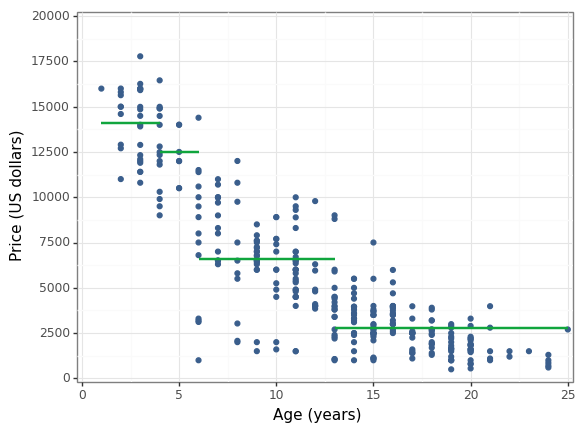

<ggplot: (396976824)>

In [35]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


**Note**: min_impurity_decrease in sklearn is considered to be the same as cp in caret, the actual values are different but the purpose is the same

In [36]:
cart3 = DecisionTreeRegressor(
    random_state=2018, criterion="mse", min_impurity_decrease=50000
)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)


DecisionTreeRegressor(criterion='mse', min_impurity_decrease=50000,
                      random_state=2018)

In [37]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = np.sqrt(mean_squared_error(data_test["price"], pred_cart3))
rmse_cart3


1965.104039943207

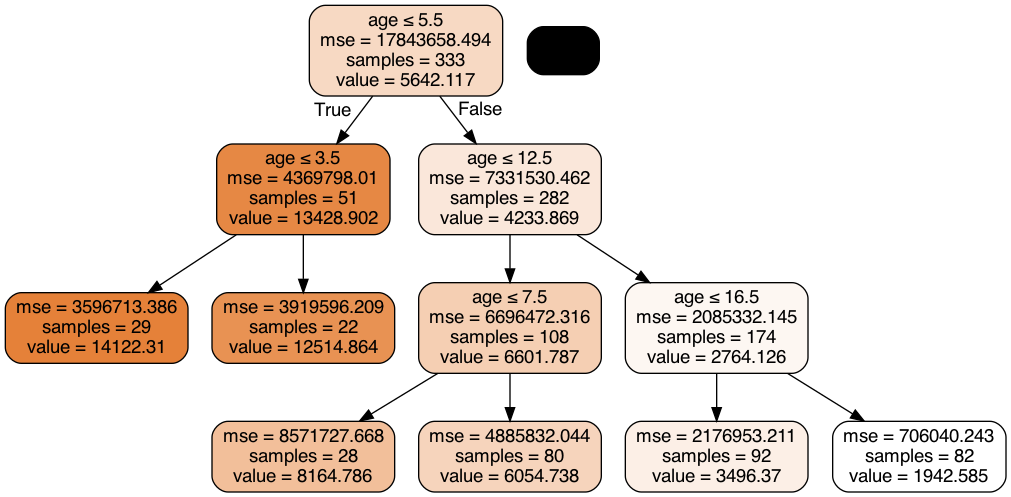

In [38]:
jupyter_graphviz(
    cart3, filled=True, rounded=True, special_characters=True, feature_names=["age"]
)


In [39]:
### Scatterplot with step function
plot_helper = seq(min(data_train["age"]), max(data_train["age"]), by=1)

plot_helper_df = pd.DataFrame({"age": plot_helper})
plot_helper_df["xend"] = pd.Series(plot_helper) + 1
plot_helper_df["yend"] = cart3.predict(plot_helper_df[["age"]])
pred_cart1t = cart3.predict(data_train[["age"]])


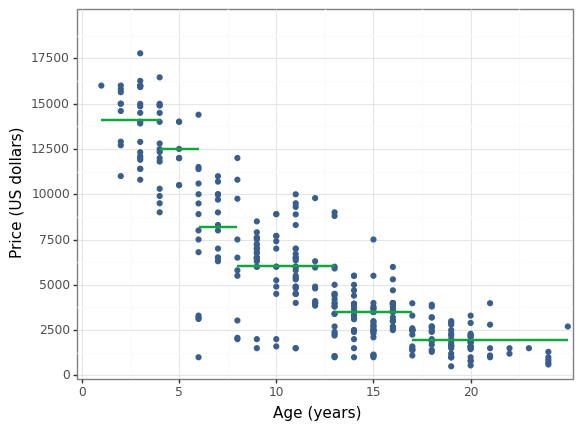

<ggplot: (678168221)>

In [40]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_segment(
        plot_helper_df,
        aes(x="age", y="yend", xend="xend", yend="yend"),
        color=color[1],
        size=1,
        na_rm=True,
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


#### Age only linear regression
---

In [41]:
linreg1 = smf.ols("price~age", data=data_train).fit()
linreg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     829.0
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           3.77e-92
Time:                        13:07:31   Log-Likelihood:                -3043.8
No. Observations:                 333   AIC:                             6092.
Df Residuals:                     331   BIC:                             6099.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.33e+04    293.478     45.320      0.000    1.27e+04    1.39e+04
age         -621.7128     21.593    -28.793      0.000    -664.189    -579.237
==============================================================================
Omnibus:                       12.023   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.771
Skew:                          -0.217   Prob(JB):                     5.09e-05
Kurtosis:                       4.112   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg1))
rmse_ols1


2377.286603444375

In [43]:
## Scatterplot with predicted values
pred_linreg1t = linreg1.predict(data_train)


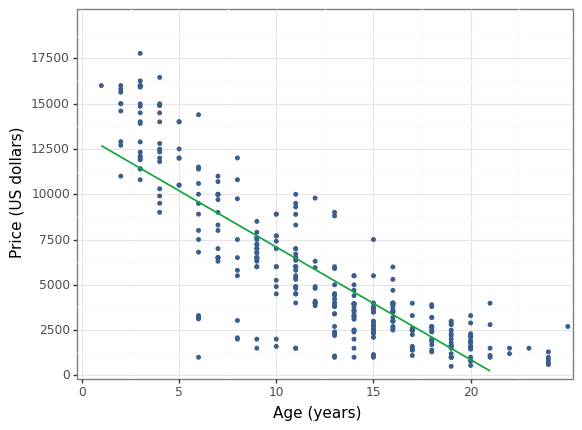

<ggplot: (390562308)>

In [44]:
(
    ggplot(data_train)
    + geom_point(
        aes(x="age", y="price"),
        color=color[0],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_line(aes(x="age", y="pred_linreg1t"), colour=color[1], size=0.7)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


In [45]:
#### Age only only lowess
lowess = sm.nonparametric.KernelReg


In [46]:
lowess1 = lowess(data_train.price, data_train.age, "c")


In [47]:
pred_lowess1 = lowess1.fit(data_test["age"])
rmse_lowess1 = np.sqrt(mean_squared_error(data_test["price"], pred_lowess1[0]))
pred_lowess1t = lowess1.fit(data_train["age"])


In [48]:
data_lowess = data_train.copy()
data_lowess["pred_lowess1t"] = pred_lowess1t[0]


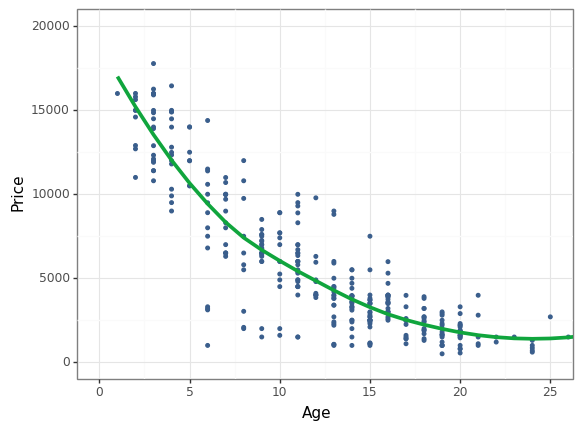

<ggplot: (394840028)>

In [49]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(size=1, colour=color[0])
    + labs(x="Age", y="Price")
    + coord_cartesian(xlim=(0, 25), ylim=(0, 20000))
    + geom_smooth(method="loess", colour=color[1], se=False, size=1.5)
    + theme_bw()
)


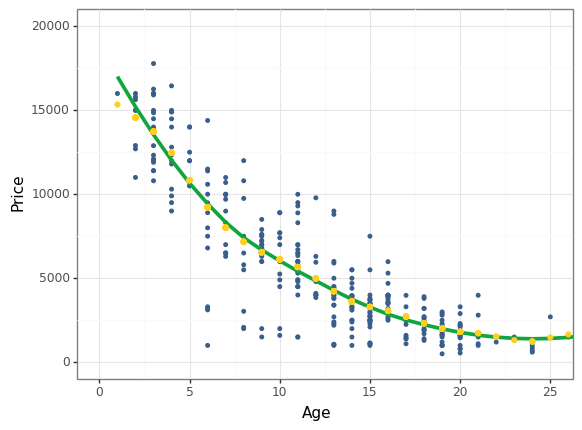

<ggplot: (679661809)>

In [50]:
### Checking kernelreg predictions (yellow points) - they look the same as loess method results.
(
    ggplot(data_lowess, aes(x="age", y="price"))
    + geom_point(size=1, colour=color[0])
    + labs(x="Age", y="Price")
    + coord_cartesian(xlim=(0, 25), ylim=(0, 20000))
    + geom_smooth(method="loess", colour=color[1], se=False, size=1.5)
    + theme_bw()
    + geom_point(aes(x="age", y="pred_lowess1t"), color=color[3])
)


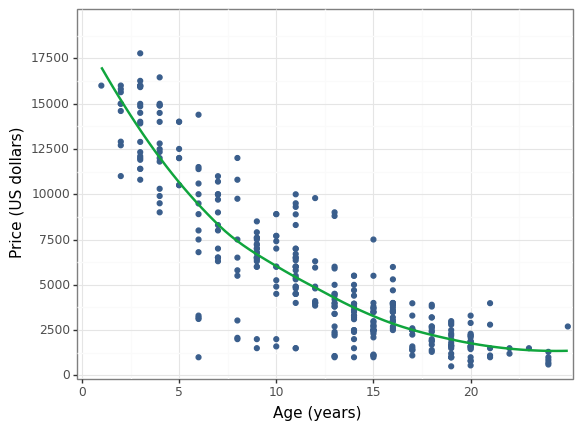

<ggplot: (679665936)>

In [51]:
(
    ggplot(data_train, aes(x="age", y="price"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="loess", se=False)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5))
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
)


### MULTIPLE PREDICTOR VARIABLES

In [52]:
# Linear regression with multiple variables
model2 = "price ~ age + odometer + LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer + chicago"
linreg2 = smf.ols(model2, data_train).fit()
linreg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     140.7
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          4.11e-111
Time:                        13:07:33   Log-Likelihood:                -2972.8
No. Observations:                 333   AIC:                             5968.
Df Residuals:                     322   BIC:                             6009.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.321e+04    461.517     28.617      0.000    1.23e+04    1.41e+04
age             -379.8449     27.716    -13.705      0.000    -434.373    -325.317
odometer        -291.1999     31.750     -9.172      0.000    -353.663    -228.737
LE              -181.0840    254.473     -0.712      0.477    -681.723     319.555
XLE               25.2264    412.679      0.061      0.951    -786.661     837.114
SE               637.5542    379.765      1.679      0.094    -109.579    1384.688
cond_excellent   438.7239    404.772      1.084      0.279    -357.607    1235.055
cond_good        416.6294    382.732      1.089      0.277    -336.342    1169.601
cylind6         -577.9067    329.939     -1.752      0.081   -1227.016      71.203
dealer          1728.6860    303.913      5.688      0.000    1130.781    2326.591
chicago          291.4590    221.515      1.316      0.189    -144.340     727.258
==============================================================================
Omnibus:                       19.037   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.160
Skew:                          -0.320   Prob(JB):                     1.41e-08
Kurtosis:                       4.482   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg2))
rmse_linreg2


1932.060345158252

In [54]:
# add squared for age, odometer
model3 = "price ~ age + agesq+ odometer+odometersq +LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer+chicago"
linreg3 = smf.ols(model3, data_train).fit()
linreg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     165.2
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          3.38e-129
Time:                        13:07:33   Log-Likelihood:                -2924.0
No. Observations:                 333   AIC:                             5874.
Df Residuals:                     320   BIC:                             5924.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.667e+04    519.450     32.086      0.000    1.56e+04    1.77e+04
age             -868.1117     84.942    -10.220      0.000   -1035.228    -700.996
agesq             18.4927      2.902      6.371      0.000      12.782      24.203
odometer        -438.9228     57.365     -7.651      0.000    -551.783    -326.063
odometersq         0.3760      0.082      4.579      0.000       0.214       0.538
LE               -15.6628    221.131     -0.071      0.944    -450.718     419.392
XLE              -19.8044    357.915     -0.055      0.956    -723.967     684.358
SE               387.5369    335.134      1.156      0.248    -271.808    1046.882
cond_excellent   467.2468    351.214      1.330      0.184    -223.733    1158.226
cond_good        182.2476    332.466      0.548      0.584    -471.848     836.343
cylind6         -371.7174    288.959     -1.286      0.199    -940.217     196.782
dealer          1248.9963    267.629      4.667      0.000     722.462    1775.531
chicago          460.4400    192.649      2.390      0.017      81.422     839.458
==============================================================================
Omnibus:                       50.502   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.987
Skew:                          -0.596   Prob(JB):                     4.11e-41
Kurtosis:                       6.462   Cond. No.                     2.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg3))
rmse_linreg3


1425.6803556123104

In [56]:
Y, X = dmatrices(model2, data_train)


In [57]:
# Tree

# Splits at four levels, for illustrative purposes
# (make sure it stops by setting "maxdepth" to 3)
cart4 = DecisionTreeRegressor(random_state=20108, criterion="mse", max_depth=3)
cart4.fit(X, Y)


DecisionTreeRegressor(criterion='mse', max_depth=3, random_state=20108)

In [58]:
y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4


1947.937392219142

In [59]:
feature_names_model2 = [
    "price",
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]


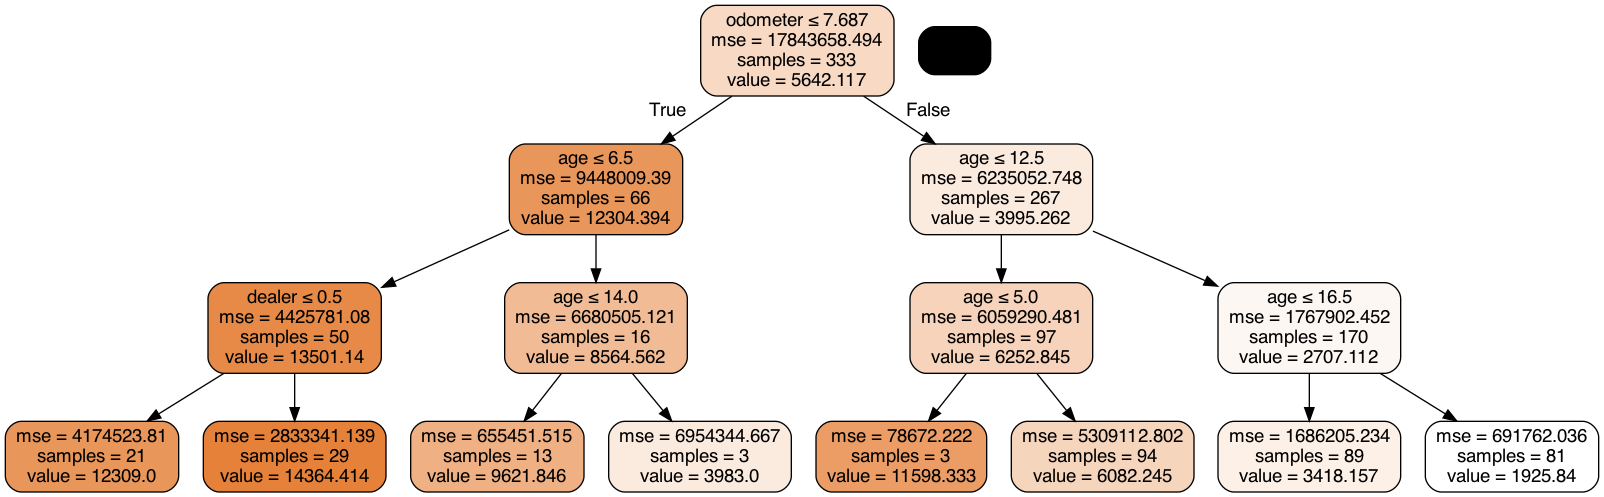

In [60]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [61]:
# alternative to show the use of min_impurity_decrease
# slightly the same outcome


In [62]:
cart4 = DecisionTreeRegressor(
    random_state=20108,
    criterion="mse",
    min_impurity_decrease=145000,
    min_samples_split=20,
)
cart4.fit(X, Y)

y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4


1924.2761573035132

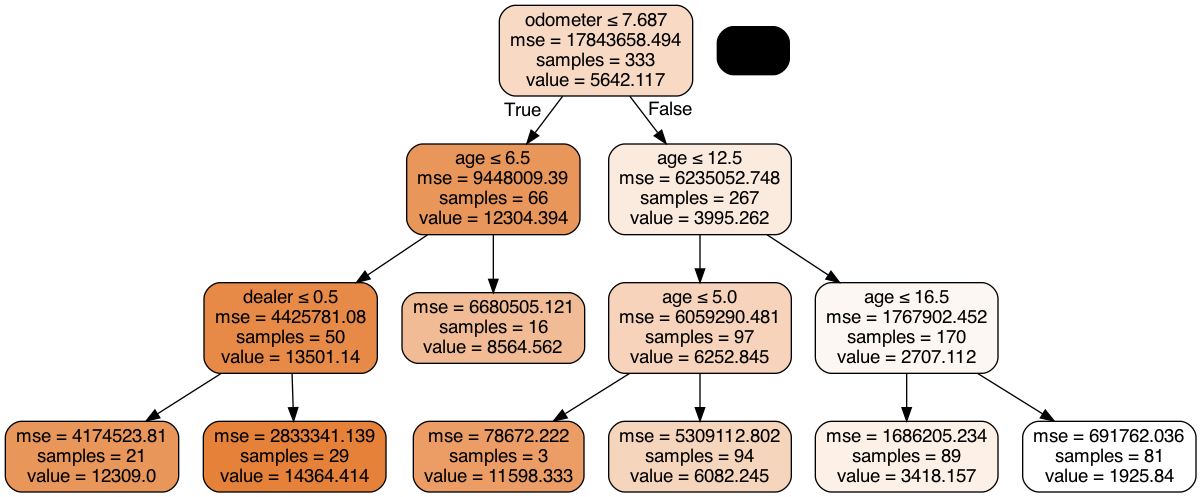

In [63]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [64]:
# CART M5
cart5 = DecisionTreeRegressor(
    random_state=20108,
    criterion="mse",
    min_impurity_decrease=20000,
)
cart5.fit(X, Y)


DecisionTreeRegressor(criterion='mse', min_impurity_decrease=20000,
                      random_state=20108)

In [65]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = np.sqrt(mean_squared_error(y_test, pred_cart5))
rmse_cart5


1873.370022392691

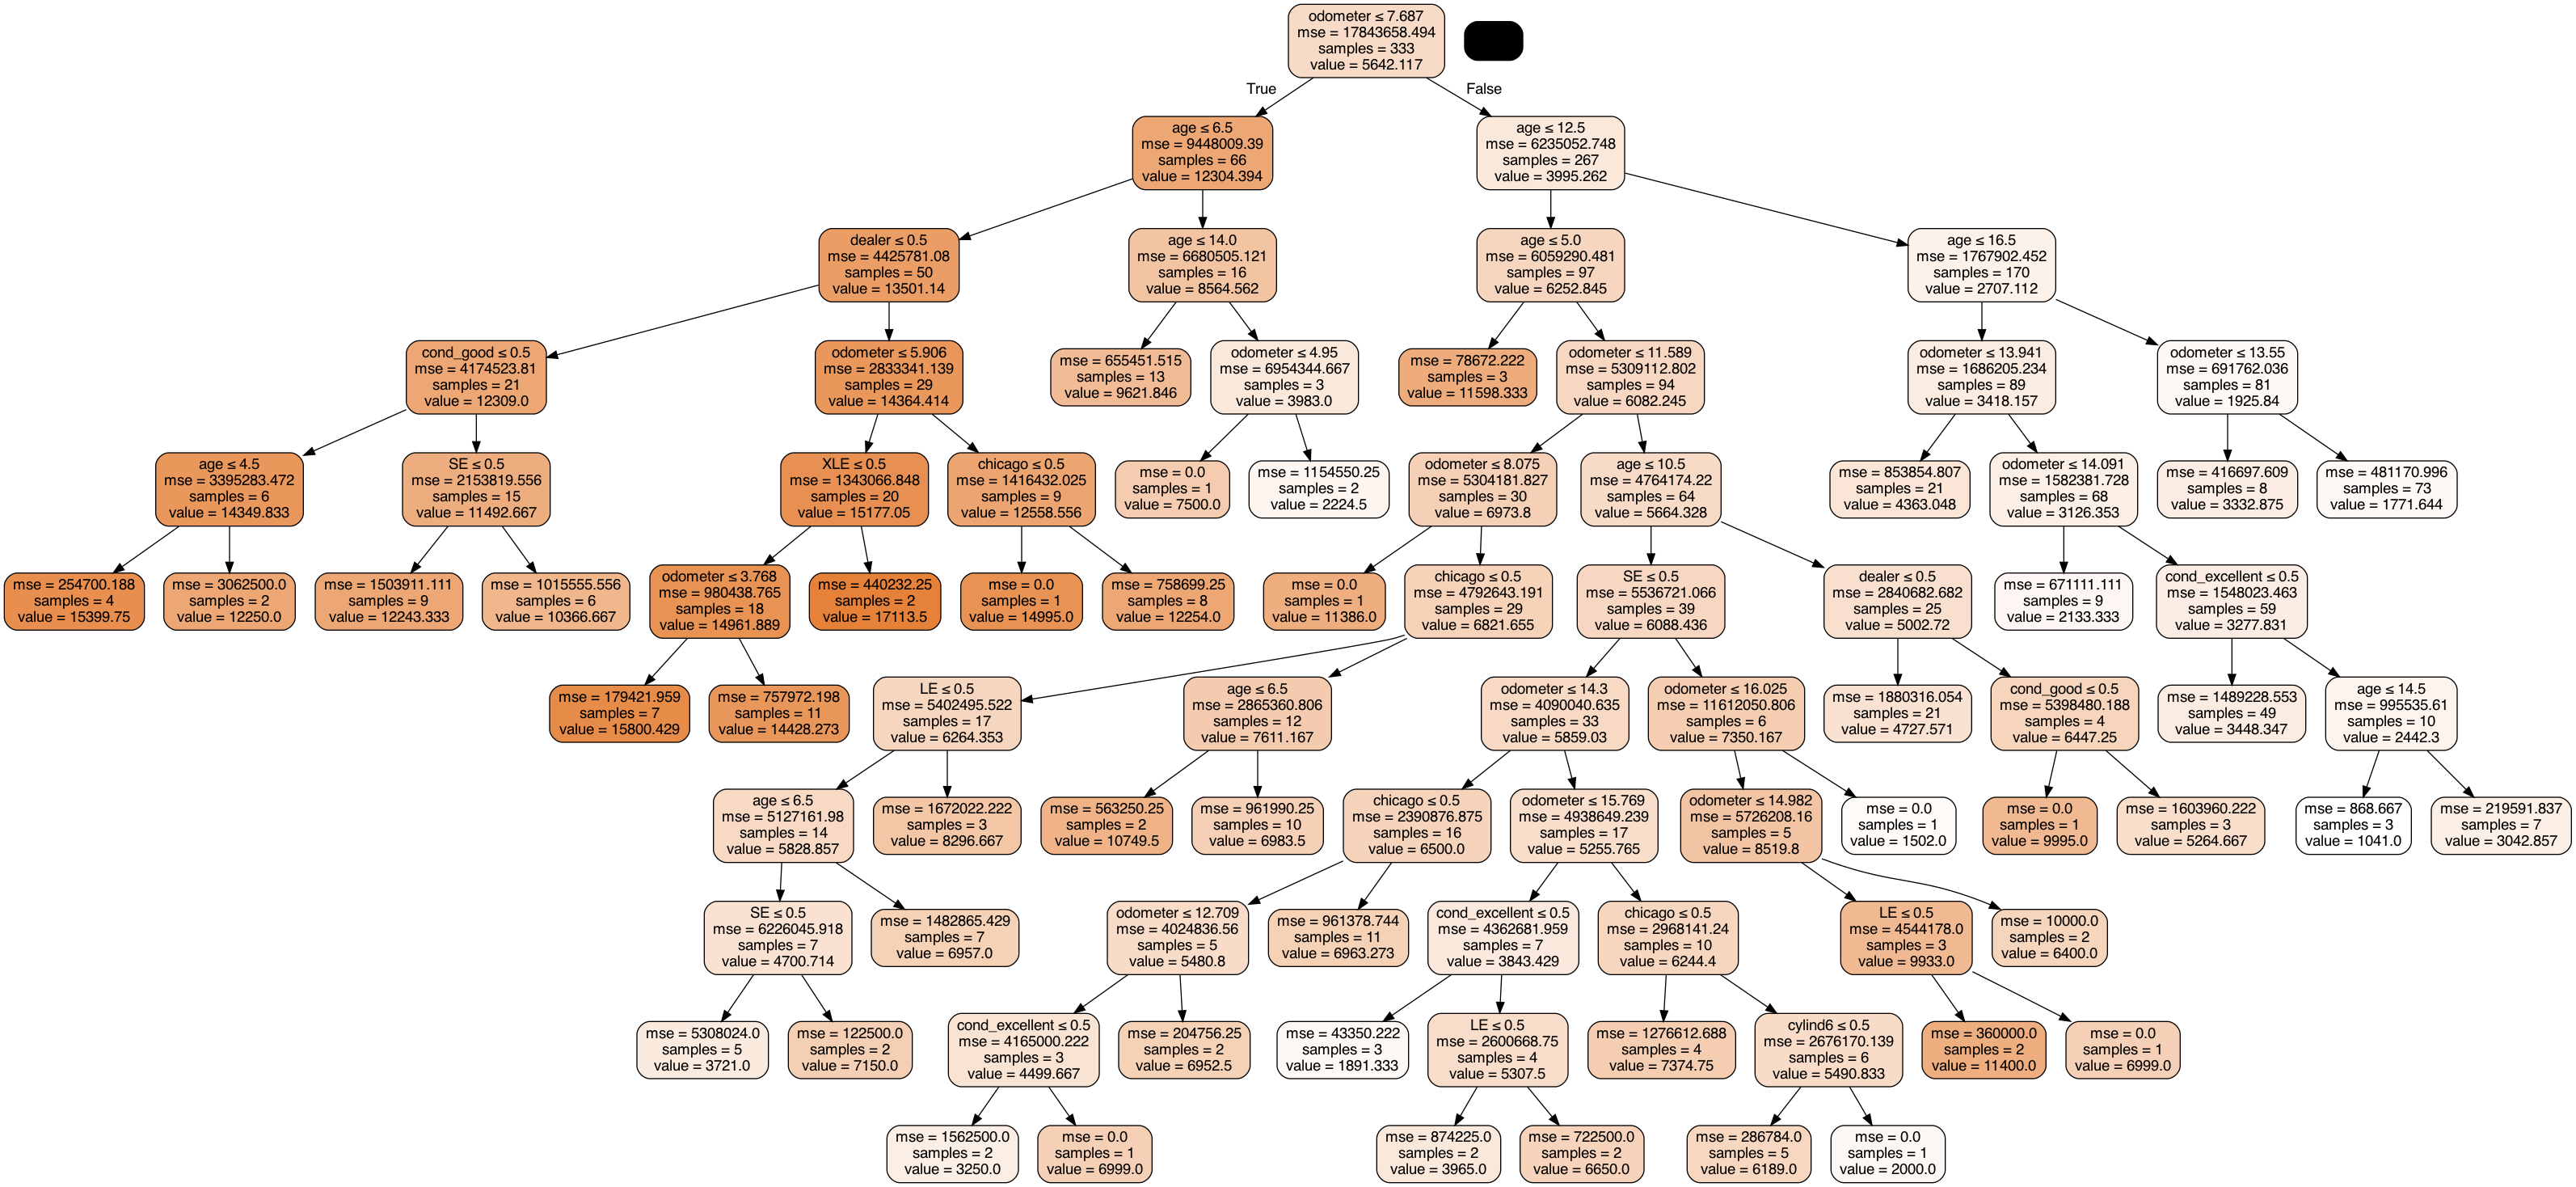

In [66]:
jupyter_graphviz(
    cart5,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


In [67]:
# build very large tree and prune it
# in Python this can be done in sklearn's DecisionTreeRegressor with ccp_alpha parameter
cart6 = DecisionTreeRegressor(
    random_state=20108, min_samples_split=4, criterion="mse", ccp_alpha=30000
)
cart6.fit(X, Y)


DecisionTreeRegressor(ccp_alpha=30000, criterion='mse', min_samples_split=4,
                      random_state=20108)

In [68]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = np.sqrt(mean_squared_error(y_test, pred_cart6))
rmse_cart6


1691.655225956562

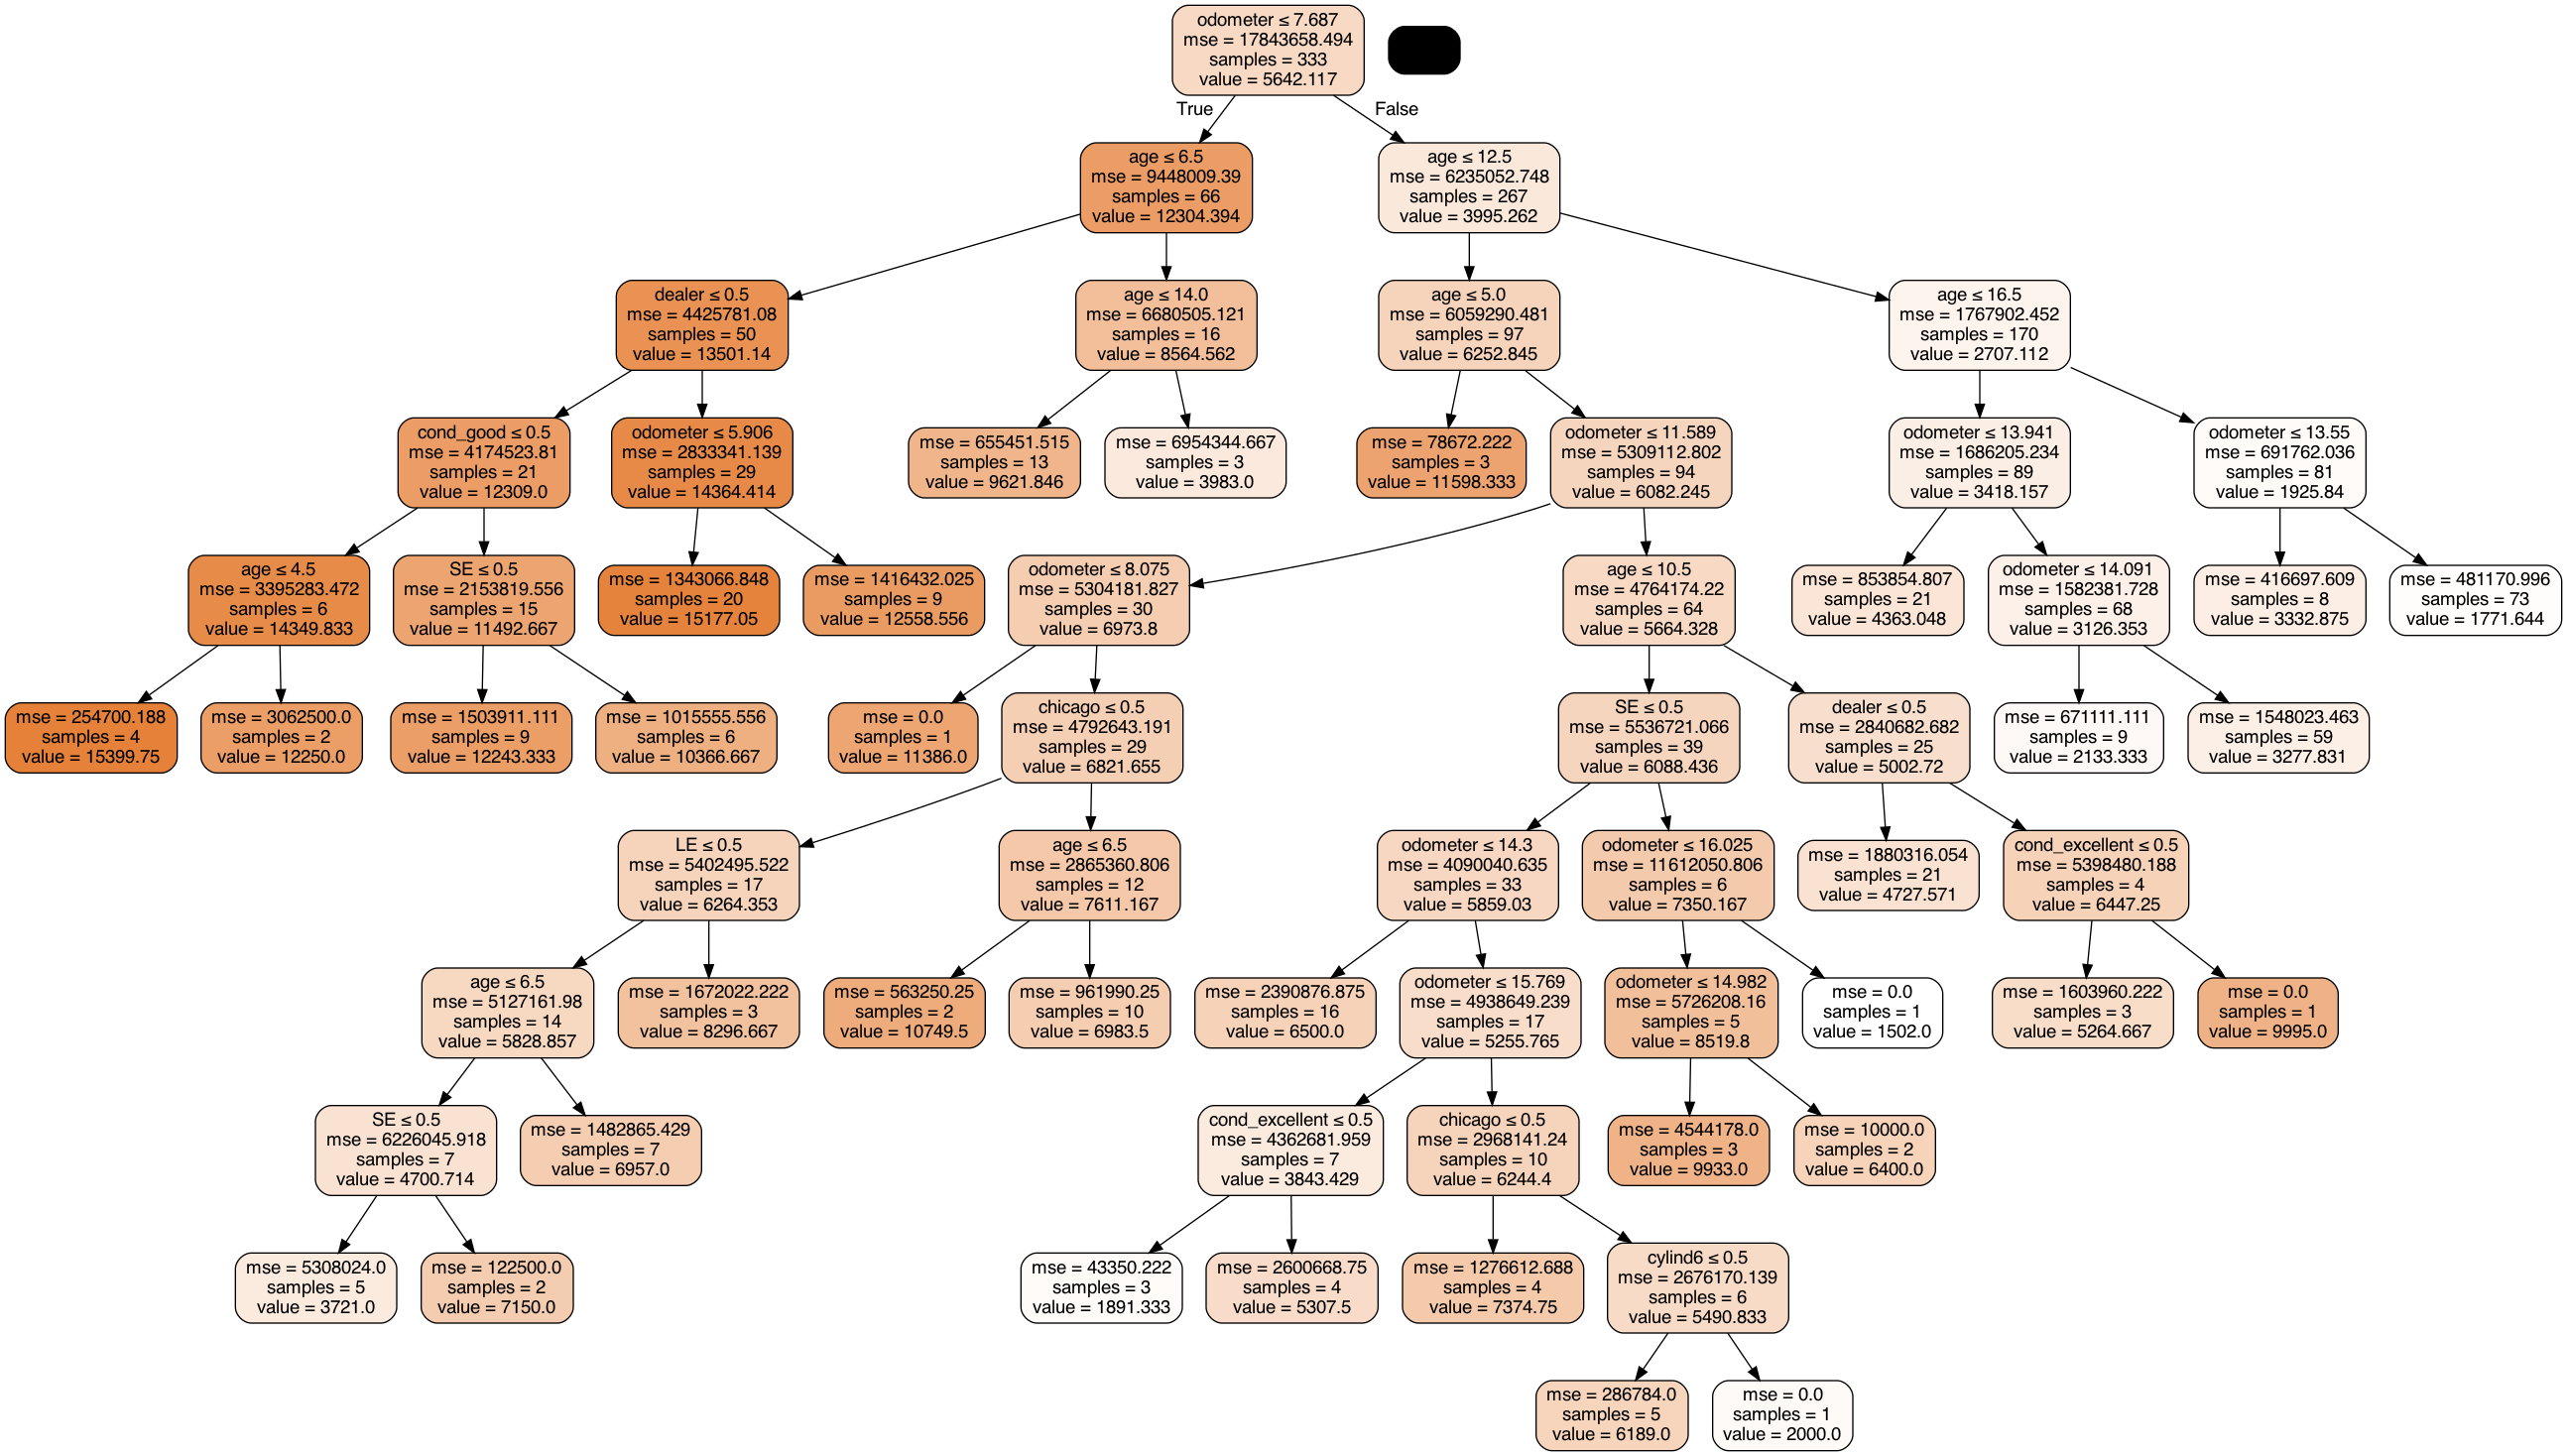

In [69]:
jupyter_graphviz(
    cart6,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)


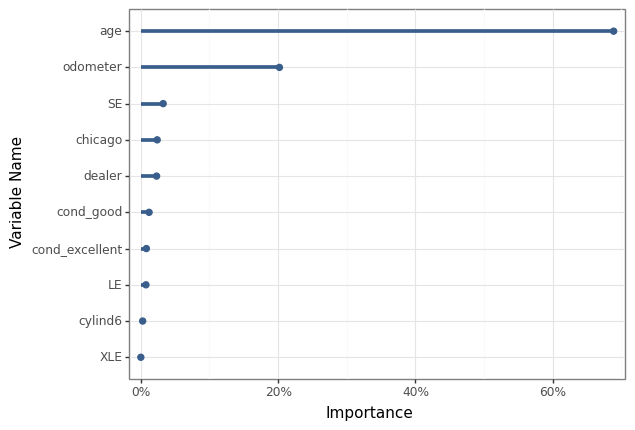

<ggplot: (679993399)>

In [70]:
# Variable (permutation) importance for model 6 (not in book)

perm_imp = permutation_importance(cart6, X, Y, n_repeats=500, scoring="r2")

cart4_var_imp_df = (
    pd.DataFrame(perm_imp["importances_mean"], feature_names_model2)
    .iloc[1:, :]
    .rename({0: "Importance"}, axis=1)
    .sort_values(by=["Importance"], ascending=False)
    .reset_index()
)

cart4_var_imp_df["Importance"] = (
    cart4_var_imp_df["Importance"] / cart4_var_imp_df["Importance"].sum()
)

(
    ggplot(cart4_var_imp_df, aes(x="reorder(index,Importance)", y="Importance"))
    + geom_point(color=color[0], size=2)
    + geom_segment(
        aes(x="index", xend="index", y=0, yend="Importance"), color=color[0], size=1.5
    )
    + ylab("Importance")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + theme_bw()
)


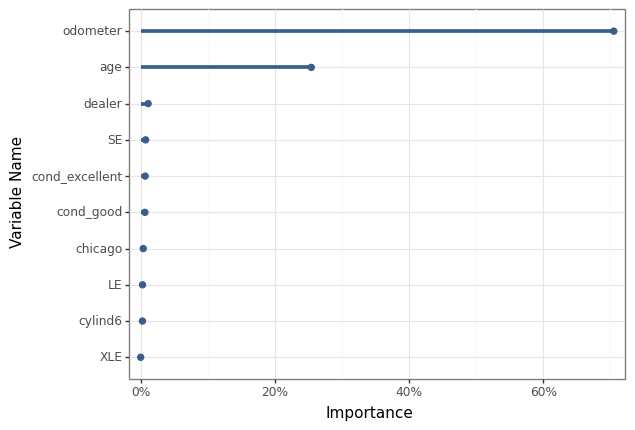

<ggplot: (679939494)>

In [71]:
# Variable importance for model 6

cart6_var_imp_df = (
    pd.DataFrame(cart6.feature_importances_, feature_names_model2)
    .iloc[1:, :]
    .rename({0: "Importance"}, axis=1)
    .sort_values(by=["Importance"], ascending=False)
    .reset_index()
)
(
    ggplot(cart6_var_imp_df, aes(x="reorder(index,Importance)", y="Importance"))
    + geom_point(color=color[0], size=2)
    + geom_segment(
        aes(x="index", xend="index", y=0, yend="Importance"), color=color[0], size=1.5
    )
    + ylab("Importance")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + theme_bw()
)


In [72]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model")


,Number of variables,Model details,RMSE
Model,,,
CART M1,1,2 levels,3105.589314
CART M2,1,3 levels,2275.405316
CART M3,7,min_impurity_decrease=50000,1965.104040
CART M4,7,min_impurity_decrease=140000 & min_samples_spl...,1924.276157
CART M5,7,min_impurity_decrease=20000,1873.370022
CART M6,7,ccp_alpha=30000,1691.655226
OLS M1,1,linear,2377.286603
OLS M2,7,linear,1932.060345
OLS M3,7,w/ polynomial terms,1425.680356
